In [ ]:
!pip install kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d umairshahpirzada/birds-20-species-image-classification

 82% 57.0M/69.3M [00:01<00:00, 44.1MB/s]
100% 69.3M/69.3M [00:01<00:00, 45.5MB/s]


In [ ]:
!unzip birds-20-species-image-classification.zip

Archive:  birds-20-species-image-classification.zip
  inflating: images to predict/1.jpg  
  inflating: images to predict/2.jpg  
  inflating: images to predict/3.jpg  
  inflating: images to predict/4.jpg  
  inflating: images to predict/5.jpg  
  inflating: images to predict/6.jpg  
  inflating: test/ABBOTTS BABBLER/1.jpg  
  inflating: test/ABBOTTS BABBLER/2.jpg  
  inflating: test/ABBOTTS BABBLER/3.jpg  
  inflating: test/ABBOTTS BABBLER/4.jpg  
  inflating: test/ABBOTTS BABBLER/5.jpg  
  inflating: test/ABBOTTS BOOBY/1.jpg  
  inflating: test/ABBOTTS BOOBY/2.jpg  
  inflating: test/ABBOTTS BOOBY/3.jpg  
  inflating: test/ABBOTTS BOOBY/4.jpg  
  inflating: test/ABBOTTS BOOBY/5.jpg  
  inflating: test/ABYSSINIAN GROUND HORNBILL/1.jpg  
  inflating: test/ABYSSINIAN GROUND HORNBILL/2.jpg  
  inflating: test/ABYSSINIAN GROUND HORNBILL/3.jpg  
  inflating: test/ABYSSINIAN GROUND HORNBILL/4.jpg  
  inflating: test/ABYSSINIAN GROUND HORNBILL/5.jpg  
  inflating: test/AFRICAN CROWNED CRANE

In [ ]:
import os
import cv2
import time
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torch.utils.data import RandomSampler

import torchvision.transforms as T
import torchvision.models as models
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder

from matplotlib import pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid

In [ ]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    else:
        return torch.device("cpu")
device = get_default_device()
device

device(type='cuda')

In [ ]:
classes = os.listdir("./train")
classes

['AFRICAN EMERALD CUCKOO',
 'AFRICAN PYGMY GOOSE',
 'ABBOTTS BABBLER',
 'ALBERTS TOWHEE',
 'ABYSSINIAN GROUND HORNBILL',
 'ABBOTTS BOOBY',
 'AMERICAN FLAMINGO',
 'AMERICAN KESTREL',
 'ALEXANDRINE PARAKEET',
 'AFRICAN PIED HORNBILL',
 'AMERICAN AVOCET',
 'ALTAMIRA YELLOWTHROAT',
 'ALBATROSS',
 'AFRICAN CROWNED CRANE',
 'AFRICAN OYSTER CATCHER',
 'AMERICAN GOLDFINCH',
 'ALPINE CHOUGH',
 'AMERICAN BITTERN',
 'AFRICAN FIREFINCH',
 'AMERICAN COOT']

In [ ]:
print(len(classes))

20


In [ ]:
# Define the transformations to apply to the data
transform = transforms.Compose([
    transforms.Resize((227, 227)),  # Resize images to a consistent size
    transforms.Compose([
    transforms.RandomRotation(10),      # rotate +/- 10 degrees
    transforms.RandomHorizontalFlip(),  # reverse 50% of images
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                          [0.229, 0.224, 0.225])
])
])

trainset = ImageFolder('./train', transform=transform)
testset = ImageFolder('./test', transform=transform)
len(trainset), len(testset)

(3208, 100)

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False)

In [ ]:
# Get the spatial size of images
sample_image, _ = trainset[0]  # Retrieve the first image sample
image_size = sample_image.shape[1:]   # Get the size of the image

print("Spatial size of images: ", image_size)
num_channels = sample_image.shape[0]

print("Number of channels:", num_channels)

Spatial size of images:  torch.Size([227, 227])
Number of channels: 3


Label: [ 4  8 17 17  7 11 12  1  1  6 10 12  0  4  1 18  1  7  5  3  0 14 14 18
 16  0 15 11 16 15 17 18]
Class: ABBOTTS BOOBY ABYSSINIAN GROUND HORNBILL ALBERTS TOWHEE ALBERTS TOWHEE ALPINE CHOUGH ALBATROSS ALTAMIRA YELLOWTHROAT ABBOTTS BABBLER ABBOTTS BABBLER AFRICAN PIED HORNBILL AMERICAN GOLDFINCH ALTAMIRA YELLOWTHROAT AMERICAN COOT ABBOTTS BOOBY ABBOTTS BABBLER AFRICAN FIREFINCH ABBOTTS BABBLER ALPINE CHOUGH AMERICAN KESTREL ALEXANDRINE PARAKEET AMERICAN COOT AMERICAN FLAMINGO AMERICAN FLAMINGO AFRICAN FIREFINCH AMERICAN BITTERN AMERICAN COOT AFRICAN CROWNED CRANE ALBATROSS AMERICAN BITTERN AFRICAN CROWNED CRANE ALBERTS TOWHEE AFRICAN FIREFINCH


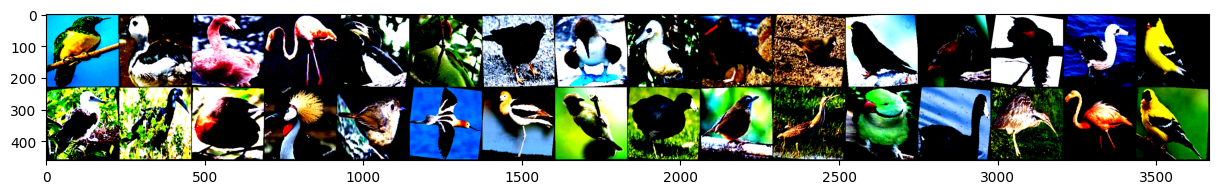

In [ ]:
for images, labels in trainloader:
    break
#print the labels
print('Label:', labels.numpy())
print('Class:', *np.array([classes[i] for i in labels]))

im=make_grid(images,nrow=16)
plt.figure(figsize=(15,15))
plt.imshow(np.transpose(im.numpy(),(1,2,0)))

In [ ]:
class AlexNet(nn.Module):
  def __init__(self, num_classes=20):
    super(AlexNet, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(3, 96, 11, stride=4),
        nn.BatchNorm2d(96),
        nn.ReLU(),
        # nn.LocalResponseNorm(5, 0.0001, 0.75, 2),
        nn.MaxPool2d(3, 2)
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(96, 256, 5, 1, padding=2),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        # nn.LocalResponseNorm(5, 0.0001, 0.75, 2),
        nn.MaxPool2d(3, 2)
    )
    self.layer3 = nn.Sequential(
        nn.Conv2d(256, 384, 3, 1, padding=1),
        nn.BatchNorm2d(384),
        nn.ReLU()
    )
    self.layer4 = nn.Sequential(
        nn.Conv2d(384, 384, 3, 1, padding=1),
        nn.BatchNorm2d(384),
        nn.ReLU()
    )
    self.layer5 = nn.Sequential(
        nn.Conv2d(384, 256, 3, 1, padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),
        nn.MaxPool2d(3, 2)
    )
    self.fc1 = nn.Sequential(
        nn.Linear(9216, 1024),
        nn.ReLU()
    )
    self.fc2 = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(1024, num_classes),
        nn.LogSoftmax(dim=1)
    )

  def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.view(-1, 256*6*6)
        out = self.fc1(out)
        out = self.fc2(out)
        return out



In [ ]:
alex_net = AlexNet()
alex_net = alex_net.to(device)
alex_net.cuda()

AlexNet(
  (layer1): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer4): Sequential(
    (0): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  

In [ ]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(alex_net.parameters(), lr=0.001)

In [ ]:
def train(model):
  num_epochs = 10
  total_step = len(trainloader)
  # Training loop
  for epoch in range(num_epochs):
      for i, data in enumerate(trainloader, 0):
          inputs, labels = data
          inputs = inputs.to(device)
          labels = labels.to(device)
          optimizer.zero_grad()

          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                    .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
      print('Epoch finished')

  print('Training finished!')

In [ ]:
train(alex_net)

Epoch [1/10], Step [1/101], Loss: 3.1737
Epoch [1/10], Step [2/101], Loss: 3.1706
Epoch [1/10], Step [3/101], Loss: 3.0118
Epoch [1/10], Step [4/101], Loss: 3.0160
Epoch [1/10], Step [5/101], Loss: 3.0336
Epoch [1/10], Step [6/101], Loss: 3.0739
Epoch [1/10], Step [7/101], Loss: 2.9973
Epoch [1/10], Step [8/101], Loss: 3.0809
Epoch [1/10], Step [9/101], Loss: 2.9053
Epoch [1/10], Step [10/101], Loss: 2.9633
Epoch [1/10], Step [11/101], Loss: 3.0770
Epoch [1/10], Step [12/101], Loss: 2.8230
Epoch [1/10], Step [13/101], Loss: 3.1395
Epoch [1/10], Step [14/101], Loss: 3.0473
Epoch [1/10], Step [15/101], Loss: 3.0394
Epoch [1/10], Step [16/101], Loss: 3.0282
Epoch [1/10], Step [17/101], Loss: 2.7763
Epoch [1/10], Step [18/101], Loss: 2.9451
Epoch [1/10], Step [19/101], Loss: 2.9270
Epoch [1/10], Step [20/101], Loss: 3.0344
Epoch [1/10], Step [21/101], Loss: 2.8728
Epoch [1/10], Step [22/101], Loss: 2.9252
Epoch [1/10], Step [23/101], Loss: 2.9757
Epoch [1/10], Step [24/101], Loss: 2.8782
E

In [ ]:
def test(model):
  # Test the model
  correct = 0
  total = 0
  with torch.no_grad():
      for data in testloader:
          images, labels = data
          images = images.to(device)
          labels = labels.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print('Accuracy of the network on the test images: %d %%' % (
      100 * correct / total))

In [ ]:
test(alex_net)

Accuracy of the network on the test images: 67 %


In [ ]:
alex= models.alexnet(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:05<00:00, 43.5MB/s]


In [ ]:
for param in alex.parameters():
    param.requires_grad=False

In [ ]:
torch.manual_seed(42)

alex.classifier=nn.Sequential(  nn.Linear(9216,1024),
                                nn.ReLU(),
                                nn.Dropout(p=0.5),
                                nn.Linear(1024,len(classes)),
                                nn.LogSoftmax(dim=1))

In [ ]:
alex = alex.to(device)
alex.cuda()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, 

In [ ]:
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(alex.classifier.parameters(),lr=0.001)

In [ ]:
train(alex)


Epoch [1/10], Step [1/101], Loss: 3.0322
Epoch [1/10], Step [2/101], Loss: 6.4914
Epoch [1/10], Step [3/101], Loss: 8.8729
Epoch [1/10], Step [4/101], Loss: 5.8030
Epoch [1/10], Step [5/101], Loss: 6.9949
Epoch [1/10], Step [6/101], Loss: 4.7696
Epoch [1/10], Step [7/101], Loss: 7.4249
Epoch [1/10], Step [8/101], Loss: 6.3890
Epoch [1/10], Step [9/101], Loss: 6.4613
Epoch [1/10], Step [10/101], Loss: 3.4606
Epoch [1/10], Step [11/101], Loss: 4.6425
Epoch [1/10], Step [12/101], Loss: 3.3393
Epoch [1/10], Step [13/101], Loss: 4.0206
Epoch [1/10], Step [14/101], Loss: 1.5981
Epoch [1/10], Step [15/101], Loss: 3.0197
Epoch [1/10], Step [16/101], Loss: 2.4464
Epoch [1/10], Step [17/101], Loss: 1.9869
Epoch [1/10], Step [18/101], Loss: 1.4736
Epoch [1/10], Step [19/101], Loss: 2.3570
Epoch [1/10], Step [20/101], Loss: 1.8464
Epoch [1/10], Step [21/101], Loss: 1.4445
Epoch [1/10], Step [22/101], Loss: 0.9376
Epoch [1/10], Step [23/101], Loss: 1.2779
Epoch [1/10], Step [24/101], Loss: 1.1445
E

In [ ]:
test(alex)

Accuracy of the network on the test images: 94 %


In [ ]:
pip install efficientnet_pytorch

In [ ]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b4')

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b4-6ed6700e.pth
100%|██████████| 74.4M/74.4M [00:00<00:00, 109MB/s]


Loaded pretrained weights for efficientnet-b4


In [ ]:
model

In [ ]:
for param in model.parameters():
    param.requires_grad=False

In [ ]:
in_features = model._fc.in_features
model._fc = torch.nn.Linear(in_features, 20)

# Now set the 'requires_grad' property to True for the parameters of the custom head
for param in model._fc.parameters():
    param.requires_grad = True

In [ ]:
model = model.to(device)
model.cuda()

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        48, 48, kernel_size=(3, 3), stride=[1, 1], groups=48, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(48, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        48, 12, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        12, 48, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False
  

In [ ]:
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)

In [ ]:
train(model)

Epoch [1/10], Step [1/101], Loss: 0.3105
Epoch [1/10], Step [2/101], Loss: 0.1753
Epoch [1/10], Step [3/101], Loss: 0.1596
Epoch [1/10], Step [4/101], Loss: 0.1821
Epoch [1/10], Step [5/101], Loss: 0.1189
Epoch [1/10], Step [6/101], Loss: 0.1855
Epoch [1/10], Step [7/101], Loss: 0.1484
Epoch [1/10], Step [8/101], Loss: 0.0961
Epoch [1/10], Step [9/101], Loss: 0.2794
Epoch [1/10], Step [10/101], Loss: 0.1936
Epoch [1/10], Step [11/101], Loss: 0.2512
Epoch [1/10], Step [12/101], Loss: 0.2251
Epoch [1/10], Step [13/101], Loss: 0.1275
Epoch [1/10], Step [14/101], Loss: 0.2009
Epoch [1/10], Step [15/101], Loss: 0.2590
Epoch [1/10], Step [16/101], Loss: 0.2039
Epoch [1/10], Step [17/101], Loss: 0.4059
Epoch [1/10], Step [18/101], Loss: 0.1571
Epoch [1/10], Step [19/101], Loss: 0.1184
Epoch [1/10], Step [20/101], Loss: 0.1122
Epoch [1/10], Step [21/101], Loss: 0.0929
Epoch [1/10], Step [22/101], Loss: 0.3149
Epoch [1/10], Step [23/101], Loss: 0.1710
Epoch [1/10], Step [24/101], Loss: 0.0961
E

In [ ]:
test(model)

Accuracy of the network on the test images: 85 %


In [ ]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b1', num_classes=20)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b1-f1951068.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b1-f1951068.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 127MB/s]

Loaded pretrained weights for efficientnet-b1


In [ ]:
model = model.to(device)
model.cuda()

EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False
    

In [ ]:
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=0.001)

In [ ]:
train(model)

Epoch [1/10], Step [1/101], Loss: 3.0324
Epoch [1/10], Step [2/101], Loss: 2.8444
Epoch [1/10], Step [3/101], Loss: 2.6240
Epoch [1/10], Step [4/101], Loss: 2.4498
Epoch [1/10], Step [5/101], Loss: 2.3325
Epoch [1/10], Step [6/101], Loss: 2.1264
Epoch [1/10], Step [7/101], Loss: 1.9131
Epoch [1/10], Step [8/101], Loss: 1.6169
Epoch [1/10], Step [9/101], Loss: 1.7709
Epoch [1/10], Step [10/101], Loss: 1.3859
Epoch [1/10], Step [11/101], Loss: 1.3555
Epoch [1/10], Step [12/101], Loss: 1.6052
Epoch [1/10], Step [13/101], Loss: 1.3486
Epoch [1/10], Step [14/101], Loss: 1.2763
Epoch [1/10], Step [15/101], Loss: 1.0020
Epoch [1/10], Step [16/101], Loss: 1.0399
Epoch [1/10], Step [17/101], Loss: 0.9778
Epoch [1/10], Step [18/101], Loss: 1.3411
Epoch [1/10], Step [19/101], Loss: 0.7577
Epoch [1/10], Step [20/101], Loss: 0.6756
Epoch [1/10], Step [21/101], Loss: 0.6310
Epoch [1/10], Step [22/101], Loss: 0.3101
Epoch [1/10], Step [23/101], Loss: 0.4341
Epoch [1/10], Step [24/101], Loss: 0.4667
E

In [ ]:
test(model)

Accuracy of the network on the test images: 95 %
